In [40]:
using CSV
using Random
using StatsBase
using DataFrames
using Turing
using StatsPlots
using StatsFuns
using LaTeXStrings
using StatisticalRethinking: link
using StatisticalRethinkingPlots
using ParetoSmoothedImportanceSampling
using Logging

default(labels=false)
Logging.disable_logging(Logging.Warn);

# 8.1 Building an interaction

Code 8.1

In [41]:
d = DataFrame(CSV.File("data/rugged.csv"))
dd = d[completecases(d, :rgdppc_2000),:]
dd[:,:log_gdp] = log.(dd.rgdppc_2000);
dd[:,:log_gdp_std] = dd.log_gdp / mean(dd.log_gdp)
dd[:,:rugged_std] = dd.rugged / maximum(dd.rugged);

Code 8.2

In [42]:
r̄ = mean(dd.rugged_std)

@model function model_m8_1(rugged_std, log_gdp_std)
    σ ~ Exponential()
    a ~ Normal(1, 1)
    b ~ Normal(0, 1)
    μ = @. a + b * (rugged_std - r̄)
    log_gdp_std ~ MvNormal(μ, σ)
end

model_m8_1 (generic function with 2 methods)

Code 8.3

In [43]:
m8_1_p = sample(model_m8_1(dd.rugged_std, dd.log_gdp_std), Prior(), 1000)
m8_1_p_df = DataFrame(m8_1_p);

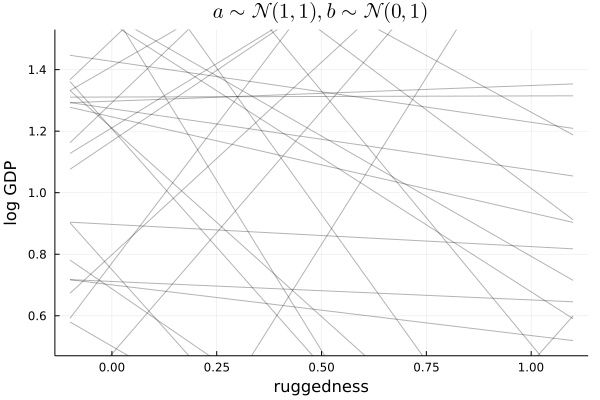

In [44]:
rugged_seq = range(-0.1, 1.1; length=30)
μ = link(m8_1_p_df, (r, x) -> r.a + r.b*(x - r̄), rugged_seq)
μ = hcat(μ...)

p = plot(
    ylim=[0.5, 1.5],
    title=L"a \sim \mathcal{N}(1,1), b \sim \mathcal{N}(0, 1)",
    xlab="ruggedness", ylab="log GDP",
)
for μ₀ ∈ first(eachrow(μ), 50)
    plot!(rugged_seq, μ₀; c=:black, alpha=0.3)
end
p